<a href="https://colab.research.google.com/github/UiinKim/UiinKim/blob/main/%EB%84%A4%EC%9D%B4%EB%B2%84_%EC%87%BC%ED%95%91_%EB%A6%AC%EB%B7%B0_%EA%B0%90%EC%84%B1_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#GPU사용
import torch
import torchvision
import torch.nn

In [2]:
!pip3 install --upgrade torch torchvision

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [5]:
#"""이전것 import부분 tf.으로 다 바꿔줌"""#
#""" from keras.models import Sequential"""
#""" from keras import layers"""
#""" from keras.optimizers import RMSprop"""

from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
# with tf.device('/device:GPU:0'):에서 모델 돌리기

In [6]:
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 49.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.6/581.6 kB 6.8 MB/s eta 0:00:00
  Created wheel for mecab-python: filename=mecab_python-1.0.0-py3-none-any.whl size=1229 sha256=1ae2f74f2f6fbfa9e313581246e617cef8763e160c496e8f2d4a1fa4a80e1684
  Stored in directory: /root/.cache/pip/wheels/ec/41/c8/ce8fb469be2547ce596c4000613806505dc54c296aae45da71
Successfully built mecab-python
Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0  1073k      0  0:00:01  0:00:01 --:--:-- 6870k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/example/ex

In [7]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [10]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7ae3b8df22f0>)

In [11]:
total_data=pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 : ', len(total_data))

전체 리뷰 개수 :  200000


In [12]:
total_data.head()

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [14]:
total_data['label']=np.select([total_data['ratings']>3], [1], default=0)
total_data.head()

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [15]:
total_data.nunique()

ratings         4
reviews    199908
label           2
dtype: int64

In [16]:
total_data.drop_duplicates(subset=['reviews'], inplace=True)
print(len(total_data))

199908


In [17]:
total_data.isnull().any()

ratings    False
reviews    False
label      False
dtype: bool

In [18]:
train_data, test_data=train_test_split(total_data, test_size=0.25, random_state=42)
print("훈련 데이터의 개수 : ", len(train_data))
print("테스트 데이터의 개수 : ", len(test_data))

훈련 데이터의 개수 :  149931
테스트 데이터의 개수 :  49977


<Axes: >

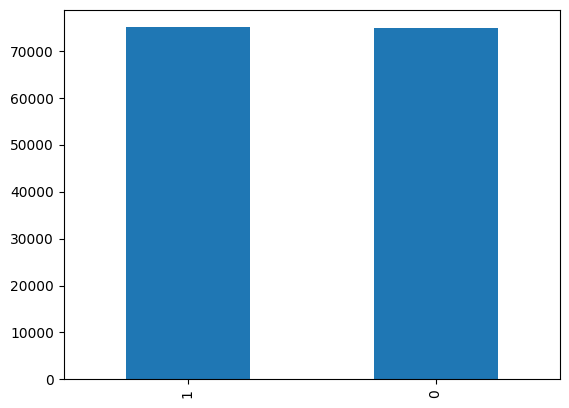

In [19]:
train_data['label'].value_counts().plot(kind='bar')

In [20]:
print(train_data.groupby('label').size().reset_index(name="count"))

   label  count
0      0  74918
1      1  75013


In [31]:
#데이터 정제
train_data['reviews']=train_data['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', '')
train_data['reviews'].replace('', np.nan, inplace=True)
train_data.isnull().sum()

<ipython-input-31-96bbb1252cda>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews']=train_data['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', '')


ratings    0
reviews    0
label      0
dtype: int64

In [32]:
test_data.drop_duplicates(subset=['reviews'], inplace=True)
test_data['reviews']=test_data['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', '')
test_data['reviews'].replace('', np.nan, inplace=True)
print(len(test_data))

49853


<ipython-input-32-91759385f557>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews']=test_data['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', '')


In [33]:
#토큰화
mecab=Mecab()
stopwords=['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [35]:
train_data['tokenized']=train_data['reviews'].apply(mecab.morphs) #형태소 분석기로 토큰화
train_data['tokenized']=train_data['tokenized'].apply(lambda x:[item for item in x if not item in stopwords]) #불용어 제거
test_data['tokenized']=test_data['reviews'].apply(mecab.morphs)
test_data['tokenized']=test_data['tokenized'].apply(lambda x:[item for item in x if not item in stopwords])

In [36]:
negative_words=np.hstack(train_data[train_data['label']==0]['tokenized'].values) #hstack으로 한 행의 배열로 쭉 묶는다.
positive_words=np.hstack(train_data[train_data['label']==1]['tokenized'].values)

In [37]:
negative_word_count=Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 29687), ('는데', 19748), ('안', 18779), ('어요', 13799), ('있', 12927), ('너무', 12576), ('했', 11492), ('좋', 9463), ('배송', 9452), ('어', 8929), ('같', 8631), ('구매', 8540), ('거', 8379), ('없', 8264), ('습니다', 8209), ('되', 8130), ('아요', 8054), ('그냥', 7927), ('않', 7757), ('잘', 7576)]


In [38]:
positive_word_count=Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 38612), ('아요', 20203), ('네요', 18965), ('잘', 18036), ('어요', 17891), ('구매', 15799), ('습니다', 13113), ('있', 12211), ('배송', 11939), ('는데', 11436), ('했', 9645), ('합니다', 9553), ('먹', 9457), ('재', 9064), ('너무', 8148), ('같', 7640), ('만족', 7071), ('어', 6628), ('아', 6531), ('거', 6261)]


긍정 리뷰의 평균 길이 :  13.22938690626958
부정 리뷰의 평균 길이 :  16.3545476387517


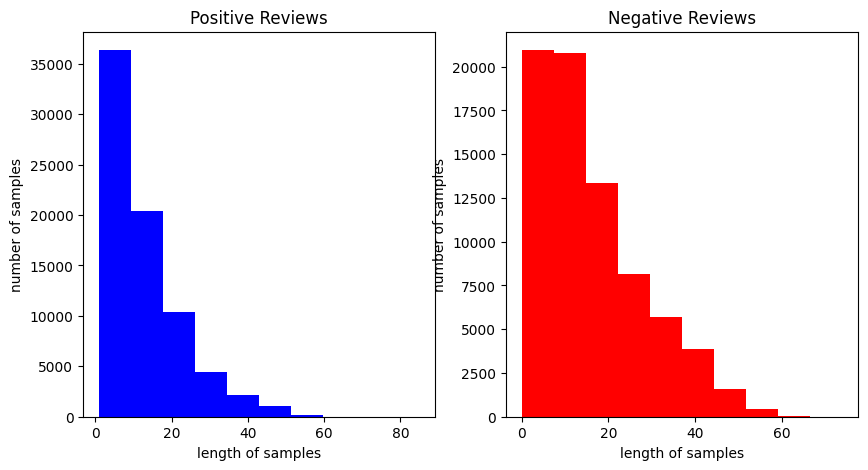

In [40]:
fig, (ax1, ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=train_data[train_data['label']==1]['tokenized'].map(lambda x:len(x)) #레이블이 1인 tokenized된 모든 문장의 길이를 저장한다.
ax1.hist(text_len, color='blue')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print("긍정 리뷰의 평균 길이 : ", np.mean(text_len))

text_len=train_data[train_data['label']==0]['tokenized'].map(lambda x:len(x))
ax2.hist(text_len, color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print("부정 리뷰의 평균 길이 : ", np.mean(text_len))
plt.show()

In [42]:
X_train=train_data['tokenized'].values #해당 열들의 값들만 빼온다.
y_train=train_data['label'].values
X_test=test_data['tokenized'].values
y_test=test_data['label'].values

In [43]:
#정수 인코딩
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_train)

In [47]:
#단어의 길이 1이하인 것들 제외
threshold=2
total_cnt=len(tokenizer.word_index)
rare_cnt=0
total_freq=0
rare_freq=0

for key, value in tokenizer.word_counts.items():
  total_freq+=value
  if value<threshold:
    rare_cnt+=1
    rare_freq+=value

print("전체에서 유니크한 단어의 비율", (rare_cnt/total_cnt)*100)
print("전체에서 유니크한 단어 빈도수의 비율", (rare_freq/total_freq)*100)
#빈도수를 보았을 때 삭제가 나음

전체에서 유니크한 단어의 비율 54.23339177868692
전체에서 유니크한 단어 빈도수의 비율 1.2553063501239614


In [48]:
vocab_size=total_cnt-rare_cnt
print("단어 집합의 크기 : ", vocab_size)

단어 집합의 크기 :  23492


In [49]:
tokenizer=Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train=tokenizer.texts_to_sequences(X_train)
X_test=tokenizer.texts_to_sequences(X_test)

제일 긴 단어의 길이 :  85
단어의 평균 길이 :  14.79097718283744


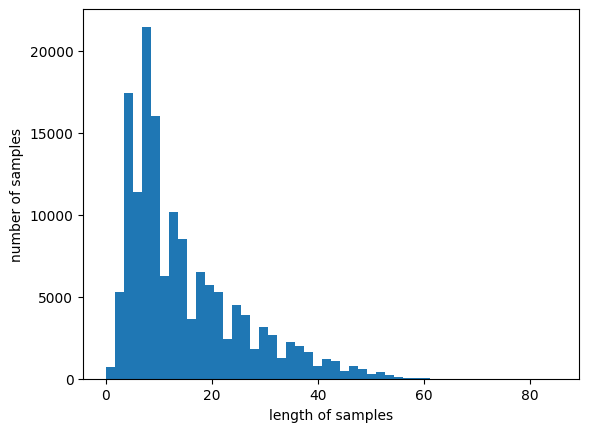

In [51]:
print("제일 긴 단어의 길이 : ", max(len(word) for word in X_train))
print("단어의 평균 길이 : ", sum(len(word) for word in X_train)/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [52]:
def below_threshold_len(max_len, nested_list):
  count=0
  for sentence in nested_list:
    if len(sentence)<=max_len:
      count+=1
  print("전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s"%(max_len, count/len(nested_list)*100))

In [56]:
max_len=80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


In [57]:
X_train=pad_sequences(X_train, maxlen=max_len)
X_test=pad_sequences(X_test, maxlen=max_len)

In [58]:
#모델 생성
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim=100
hidden_units=128

In [60]:
with tf.device('/device:GPU:0'):
  model=Sequential()
  model.add(Embedding(vocab_size, embedding_dim))
  model.add(GRU(hidden_units))
  model.add(Dense(1, activation='sigmoid'))

  es=EarlyStopping(monitor='val_loss', mode='min', patience=4, verbose=1)
  mc=ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  history=model.fit(X_train, y_train, epochs=15, batch_size=64, callbacks=[es, mc], validation_split=0.2)

Epoch 1/15
1875/1875 [==============================] - ETA: 0s - loss: 0.3053 - acc: 0.8805
Epoch 1: val_acc improved from -inf to 0.90553, saving model to best_model.h5
1875/1875 [==============================] - 55s 26ms/step - loss: 0.3053 - acc: 0.8805 - val_loss: 0.2548 - val_acc: 0.9055
Epoch 2/15
1875/1875 [==============================] - ETA: 0s - loss: 0.2405 - acc: 0.9110
Epoch 2: val_acc improved from 0.90553 to 0.91443, saving model to best_model.h5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.2405 - acc: 0.9110 - val_loss: 0.2325 - val_acc: 0.9144
Epoch 3/15
1875/1875 [==============================] - ETA: 0s - loss: 0.2179 - acc: 0.9206
Epoch 3: val_acc did not improve from 0.91443
1875/1875 [==============================] - 17s 9ms/step - loss: 0.2179 - acc: 0.9206 - val_loss: 0.2366 - val_acc: 0.9138
Epoch 4/15
1875/1875 [==============================] - ETA: 0s - loss: 0.2037 - acc: 0.9263
Epoch 4: val_acc improved from 0.91443 to 0.91616

In [64]:
loaded_model=load_model('best_model.h5')
print('\n 테스트의 정확도 : %.4f ' %(loaded_model.evaluate(X_test, y_test)[1]))

1558/1558 [==============================] - 6s 4ms/step - loss: 0.2307 - acc: 0.9150

 테스트의 정확도 : 0.9150 


In [81]:
#새로운 리뷰로 예측할 함수
def sentiment_predict(new_sentence):
  new_sentence=re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣]', '', new_sentence)
  new_sentence=mecab.morphs(new_sentence)
  new_sentence=[word for word in new_sentence if not word in stopwords]
  encoded=tokenizer.texts_to_sequences([new_sentence]) #한 줄로 묶어야함.[]
  paded=pad_sequences(encoded, maxlen=max_len)
  score=float(loaded_model.predict(paded))

  if score<0.5:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1-score)*100)) #{:.2f}는 두번째자리까지만 반올림하여 표현하는 format의 형식
  else:
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score*100))

In [82]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')

1/1 [==============================] - 0s 22ms/step
93.38% 확률로 긍정 리뷰입니다.


In [83]:
sentiment_predict('갖다 버리고 싶어요')

1/1 [==============================] - 0s 29ms/step
88.91% 확률로 부정 리뷰입니다.


In [84]:
sentiment_predict('ㅁㄴㅇㄻㄴㅇㄻㄴㅇ리뷰쓰기도 귀찮아')

1/1 [==============================] - 0s 31ms/step
54.02% 확률로 부정 리뷰입니다.
